# Training More Robust Models through Creation and Correction of Novel Model Errors 

This notebook demonstrates how to run and use `Defuse` - a method to train more robust models through creation and correction of novel model errors. Given a trained image classification model (classifier), `Defuse` generates realistically looking images which are incorrectly predicted by the classifier. Further, `Defuse` groups images into high-level model bugs and efficiently corrects them. With `Defuse` users are able to identify scenarios under which their model would fail and subsequently train a more robust model. `Defuse` works in three steps: identification, distillation, and correction. 

In the first part of the notebook, we will prepare the datasets and train the classifier as well as the generative model. In the second part we will then use these models to run `Defuse`.

    
## 1. Prepare data and model training

### 1.1 Prepare dataset

First we download the training and test datasets for [German traffic sign dataset](https://benchmark.ini.rub.de/), on which we will train the classifier and generative models. The dataset consists of 43 image classes.

In [ ]:
! wget --no-check-certificate https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
! unzip -q GTSRB-Training_fixed.zip

In [ ]:
! wget --no-check-certificate https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
! unzip -q GTSRB_Final_Test_Images.zip

We have to re-arrange the test data so that we have a separate subfolder for each image class. The file GTSRB_Final_Test_GT.zip contains a csv that shows which test image belongs to which class.

In [ ]:
! wget --no-check-certificate https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
! unzip -q GTSRB_Final_Test_GT.zip

In [4]:
import csv
import os
import shutil

if not os.path.isdir('GTSRB/GTSRB_Test'):
    os.mkdir('GTSRB/GTSRB_Test')

with open('GT-final_test.csv') as file:
    reader = csv.reader(file,delimiter=";")
    next(reader)
    for line in reader:
        image = line[0]
        classID = line[-1]
        folder = 'GTSRB/GTSRB_Test/'+ "%05d" %int(classID)
        if not os.path.isdir(folder):
            os.mkdir(folder)
        shutil.copy('GTSRB/Final_Test/Images/'+image, folder)

### 1.2 Upload data to S3

Now that we downloaded and prepared the data, we upload it to Amazon S3.

In [35]:
import boto3
import sagemaker
import os

def upload_to_s3(path, directory_name, bucket, counter=-1):
    
    print("Upload files from" + path + " to " + bucket)
    client = boto3.client('s3')
    
    for path, subdirs, files in os.walk(path):
        path = path.replace("\\","/")
        print(path)
        for file in files[0:counter]:
            client.upload_file(os.path.join(path, file), bucket, directory_name+'/'+path.split("/")[-1]+'/'+file)
            
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
bucket = sagemaker_session.default_bucket()

upload_to_s3("GTSRB/Training", directory_name="gtsrb_train",  bucket=bucket)
upload_to_s3("GTSRB/GTSRB_Test", directory_name="gtsrb_test", bucket=bucket)

### 1.3 Training scripts

The following cell shows the training script for the image classification model. It finetunes a pre-trained Resnet18 model on the German traffic sign dataset. It achieves a final test accuracy of 95%. 

In [ ]:
!pygmentize entry_point/train_classifier.py               

Let's take a look at the generative model training script. We chose a variational autoencoder (VAE). The VAE consists of an encoder and decoder. The encoder consists of 4 convolutional layers that downsample the input images. The decoder consists of 4 de-convolutional layers that reconstruct the original input image as closely as possible. In contrast to a standard autoencoder, a VAE encodes inputs as a distribution over the latent space. The decoder then samples from the latent space and decodes the input. Afterwards the reconstruction error between input and outputs are computed and the KL divergence is used to measure the divergence between the two distributions.

In [ ]:
!pygmentize entry_point/train_vae.py

### 1.4 Run SageMaker training
Now we use Amazon SageMaker to train both models on a GPU instance. Therefore, we define a PyTorch estimator which takes the training scripts and hyerparameters. 


In [32]:
import sagemaker 
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

estimator_classifier = PyTorch(entry_point='train_classifier.py',
                            source_dir='entry_point',
                            role=role,
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            framework_version='1.8.0',
                            py_version='py3',
                            hyperparameters = {'epochs': 15, 
                                               'learning_rate': 0.001},
                           )


Now we start the training on SageMaker by calling `fit()`. The function takes a dictionary that specifies the location of the training and validation data in Amazon S3. The keys of the dictionary will be the name of data channels SageMaker is creating in the training instance.

In [33]:
estimator_classifier.fit(inputs={'train': 's3://{}/gtsrb_train'.format(bucket), 
                                 'test': 's3://{}/gtsrb_test'.format(bucket)}, 
                          wait=False)


Next we start the training job for the VAE, which is trained on the same dataset.

In [36]:

estimator_vae = PyTorch(entry_point='train_vae.py',
                            source_dir='entry_point',
                            role=role,
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            framework_version='1.8.0',
                            py_version='py3',
                            hyperparameters = {'epochs': 100, 
                                                   'learning_rate': 0.001,
                                                   'batch_size':64,
                                                   'z_dimension': 15,
                                                   'beta': 4}
                           )

In [37]:
estimator_vae.fit(inputs={'train': 's3://{}/gtsrb_train'.format(bucket)},
                           wait=False) 

### 1.5 Download model

After the models have been trained, we can now download the model artifacts from Amazon S3.

In [36]:
if estimator_classifier.latest_training_job.describe()['TrainingJobStatus'] == 'Completed':  
    model_s3_path = estimator_classifier.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts']
else:
    print("Wait until training job finished.")

In [ ]:
! aws s3 cp $model_s3_path model.tar.gz
! tar xfv model.tar.gz 

In [62]:
if estimator_vae.latest_training_job.describe()['TrainingJobStatus'] == 'Completed':
    model_s3_path = estimator_vae.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts']
else:
    print("Wait until training job finished.")

In [ ]:
! aws s3 cp $model_s3_path model.tar.gz
! tar xfv model.tar.gz 

### 1.6 Generate samples
Before diving into the `Defuse` method, let's first use the VAE model to generate some new image data. We will take two test images from two different classes `A` and `B`, encode them and then perform a latent travserial, which interpolates between the two latent codes. We then take some of these interpolated latent codes and decode them into images. This will generate new images, which may not necesserialy belong to class `A` nor `B`.

First we load the model weights.

In [38]:
import torch  
from entry_point.vae_model import vae

vae_model = vae.VAE(z_dimension=15, device='cpu')
vae_model.load_state_dict(torch.load("vae.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

The following cell defines the dataloader for the test images.

In [13]:
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((64,64)), 
                                        transforms.ToTensor(),
                                        ])

dataset = datasets.ImageFolder('GTSRB/GTSRB_Test', transform)

test_dataloader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=1,
                                              shuffle=True)


Next, we display two images on which we're going to perform the latent traversal on.

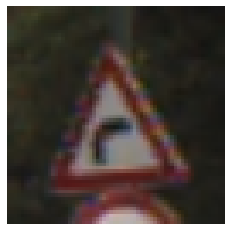

In [5]:
img1, _ = next(iter(test_dataloader))
plt.imshow(img1[0].permute(1,2,0))
plt.axis('off')
plt.show()

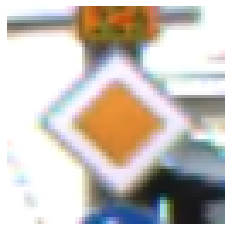

In [6]:
img2, _ = next(iter(test_dataloader))
plt.imshow(img2[0].permute(1,2,0))
plt.axis('off')
plt.show()

Now that we have selected two test images, we will interpolate between them. First we load the weights for the encoder model and encode both images.

In [39]:
import numpy as np

plt.rcParams["figure.figsize"] = (20,3)

vae_encoder = vae.Encoder(z_dimension=15).to('cpu')
vae_encoder.load_state_dict(torch.load("encoder.pt", map_location=torch.device('cpu')))

img1_encoding = vae_encoder(img1)[0]  
img2_encoding = vae_encoder(img2)[0]   

Nest we use both latent codes and interpolate between them. We append the new codes to the list `traversals`.

In [40]:
traversals = []

for i in range(img1_encoding.shape[1]):
    start = float(img1_encoding[0, i].detach().cpu().numpy())
    stop = float(img2_encoding[0, i].detach().cpu().numpy())

    traversals.append(np.linspace(start, stop, num=10))

all_traversals = torch.from_numpy(np.array(traversals)).to(torch.float).to('cpu')


The following will decode the recorded latent codes.

In [41]:

vae_decoder = vae.Decoder(z_dimension=15).to('cpu')
vae_decoder.load_state_dict(torch.load("decoder.pt", map_location=torch.device('cpu')))

decoded = vae_decoder(torch.transpose(all_traversals, 1, 0))
decoded = torch.cat([img1, decoded, img2], axis=0)

Let's display the generated images:

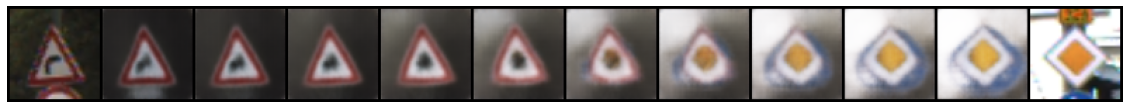

In [42]:
output = utils.make_grid(decoded, nrow=12).detach().cpu().numpy()
plt.imshow(output.transpose(1,2,0))
plt.axis('off')
plt.show()

## 2. Run Defuse 

In the first part of notebok, we have trained the models and explored, how the VAE can be used to generate new images. Now, we will focus on the `Defuse` method. The method consists of three major steps:

- Identification:  generate new image data and identify mis-classified images
- Distillation: cluster the latent codes and identify misclassification regions to label new images more efficiently
- Correction: finetune model on new image data

The following image shows an overview of the `Defuse` method.

<p>
<img src="https://raw.githubusercontent.com/amazon-research/creating-and-correcting-novel-ml-model-errors/main/images/overview.png", width="1000" height="250" />
</p>



### 2.1 Identification step
The aim of the identification step is to generate and identify the input data which are incorrectly classified. Defuse encodes all the images from the training data using the trained VAE. It then perturbs the latent codes with a small amount of noise and saves instances that are classified differently from ground truth of the original input. By perturbing the latent codes with a small amount of noise, one can expect the decoded instances to have small but semantically meaningful differences from the original instance. Thus, if the classifier prediction deviates from the perturbation, the instance is likely misclassified. The red number in the upper right-hand corner of above image is the classifier’s prediction. For instance, the generated images showing digit 0 are incorrectly classified as digit 9


In [ ]:
from torch import nn

classifier = models.resnet18()
nfeatures = classifier.fc.in_features
classifier.fc = nn.Linear(nfeatures, 43)
classifier.load_state_dict(torch.load("classifier.pt", map_location=torch.device('cpu')))
classifier.to('cpu')
classifier.eval()

Next we use the helper function `full_search` to identify latent codes that lead to mis-classifications.

In [ ]:
from naive_search import naive_latent_search, full_search

search = full_search(classifier, 
                        vae_model, 
                        test_dataloader, 
                        n_samples=10, 
                        device='cpu',
                        number_adv_examples_per_image=3)


In [45]:
misclassifications = search['mistaken_codes']
num = (misclassifications.shape)

print ("Number of generated examples that were misclassified:", num)


Number of generated examples that were misclassified: (33456, 15)


Next we decode the latent codes and use the classifier model to get the predictions for each image.

In [46]:
import plot_utils

codes_to_decode = misclassifications[np.random.choice(misclassifications.shape[0], size=64)]
decoded_examples = vae_model.decoder(torch.from_numpy(codes_to_decode).type(torch.float))
labels = (np.argmax(classifier(decoded_examples).detach().cpu().numpy(), axis=1))


Let's take a look at some of the generated images that were incorrectly predicted.

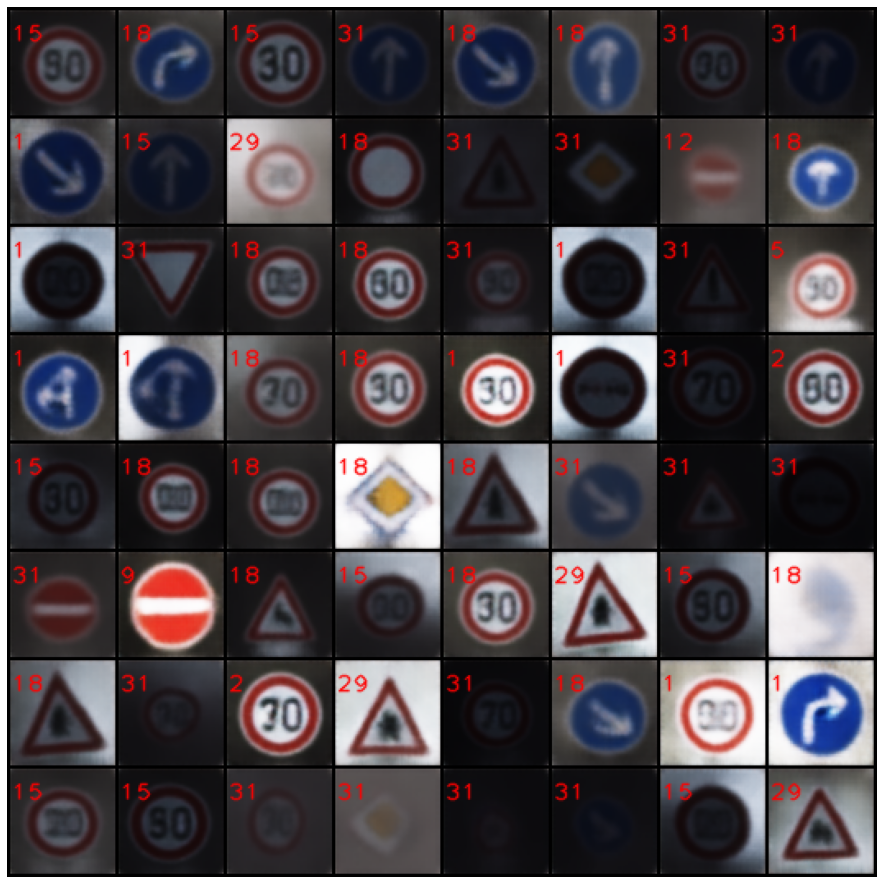

In [47]:
import torch

grid = plot_utils.create_grid_with_labels(decoded_examples.detach(), labels=labels)
fig, ax = plt.subplots(figsize=(20*4, 4*4))
plt.axis('off')
ax.imshow(grid.permute(1,2,0))


### 2.2 Defuse - Distillation
  
During the distillation step, a clustering model groups together the latent codes of the images from the previous step to diagnose misclassification regions. For instance, `Defuse` groups together generated images showing digit 8 that are incorrectly classified as 3. `Defuse` uses a Gaussian mixture model (GMM) with the Dirichlet process prior because the number of clusters is unknown ahead of time. The following image shows the t-SNE visualization of the latent codes obtained from MNIST dataset. The blue circles are the latent codes of images from the training set. The black dots correspond to the latent codes of generated images that were identified as classifier mistakes. The red dots are three decoded latent codes, where the red number in the left-hand corner is the classifier label.      


<p>
<img src="https://raw.githubusercontent.com/amazon-research/creating-and-correcting-novel-ml-model-errors/main/images/cluster.png", width="800" height="250" />
</p>

Next we define the Gaussian mixture model (GMM) with the Dirichlet process prior. We use the Dirichlet process because it describes the clustering problem where the number of mixtures is unknown beforehand. In practice, we use the truncated stick-breaking construction of the Dirichlet process, where `K` is the upper bound of the number of mixtures. Here we set `K` equals 100. 

In [48]:
from sklearn.mixture import BayesianGaussianMixture

K = 100

misclassifications = misclassifications[np.random.choice(num[0], size=10_000)]
   
gmm = BayesianGaussianMixture(n_components=K, 
                              weight_concentration_prior=None, 
                              covariance_type='full', 
                              max_iter=10_000).fit(misclassifications)

The method `BayesianGaussianMixture` outputs a set of clusters, which are desribed by 3 parameters: cluster weight, mean and variance of a multivariate normal distribution. We use those parameters to create new latent codes for each cluster:

In [49]:
imp_means = []
imp_covs = []

cutoff = 0.01

percentile = np.percentile(gmm.weights_, 75)

indices = []
for i, w in enumerate(gmm.weights_):
    if w > cutoff:
        indices.append(i)
        imp_means.append(gmm.means_[i])
        imp_covs.append(gmm.covariances_[i])


Next we decode the created latent codes:

In [50]:
decoded = vae_model.decoder(torch.from_numpy(np.array(imp_means)).to('cpu').type(torch.float))

We define a cutoff threshold, that defines how many clusters we are going to use:

In [51]:
above_cutoff = np.sum(gmm.weights_ > cutoff)
above_cutoff

37

Now we interpolate between the clusters to specify the mis-classification regions:

In [52]:
from scipy.stats import norm
means_to_decode, gaussian_centers = [], []

trav_resolution = 64
TAU = 0.01

for mean, cov in zip(imp_means, imp_covs):

    cur_decoded = np.random.multivariate_normal(mean, cov*TAU , size=trav_resolution)        
    means_to_decode.append(torch.from_numpy(np.array(cur_decoded))) 

means_to_decode = torch.stack(means_to_decode)
means_to_decode = means_to_decode.reshape((means_to_decode.shape[0] * means_to_decode.shape[1], means_to_decode.shape[2]))
decoded_traversals = vae_model.decoder(means_to_decode.to('cpu').type(torch.float)).reshape((above_cutoff, trav_resolution, 3, 64, 64))

Next we choose cluster 3 and generate some example images from this cluster that are not correctly predicted by the classifier.

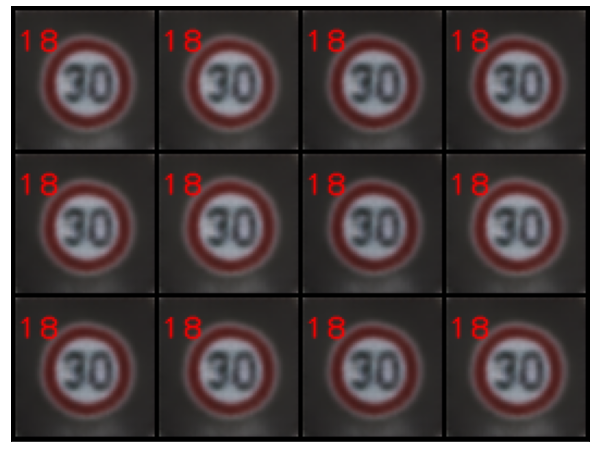

In [55]:
cluster = 3
labels = np.argmax(classifier(decoded_traversals[cluster]).detach().numpy(), axis=1)
grid = plot_utils.create_grid_with_labels(decoded_traversals[cluster].detach(), labels=labels)
fig, ax = plt.subplots(figsize=(18*4, 2*4))
plt.yticks([])
plt.xticks([])
ax.imshow(grid.permute(1,2,0))

### 2.3  Defuse - Correction

In the identification step we have determined clusters in the latent space, which generate image data which the classifier fails to predict. We export examples of these clusters, which can then be annotated by labellers. The following cell creates sample images from the clusters in the latent space and saves them in a subfolder where the name is the label.


In [45]:
! mkdir dataset_mturk

In [48]:
import os

for i in range(decoded_traversals.shape[0]):
    labels = np.argmax(classifier(decoded_traversals[i]).detach().cpu().numpy(), axis=1)

    for j in range(10):
        try:
            os.mkdir('dataset_mturk/' + str(labels[j]))

        except:
            pass
        plt.imsave("./dataset_mturk/{}/{}.png".format(labels[j], j), decoded_traversals[i][j][0].detach().numpy(), cmap="gray")


Now, you can use SageMaker Groundtruth to setup the labelling task. You can find more information here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms.html. 

Once you have labelled the new image data and uploaded it to S3, you can fine-tune the model. `Defuse` then runs the correction step using both the annotator labeled data and the original training data. It finetunes on the training data with an additional regularization term to fix the classifier performance on the misclassification regions. This objective encourages the model to maintain its predictive performance on the original training data while encouraging the model to predict the failure instances correctly. After the correction step the model correctly classifies the generated images while remaining accurate on the original data. 

Let's take a look at the training script:

In [ ]:
!pygmentize entry_point/correct_classifier.py

After you have uploaded the new image data to S3, you can run a new SageMaker training job, that uses the `correct_classifier..py` training script.

```python
import sagemaker 
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

estimator_classifier = PyTorch(entry_point='correct_classifier.py',
                            source_dir='entry_point',
                            role=role,
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            framework_version='1.8.0',
                            py_version='py3',
                            hyperparameters = {'epochs': 15, 
                                               'learning_rate': 0.001,
                                               'image_size': 128}
                              )

```

```python
estimator_classifier.fit(inputs={'train': 's3://{}/gtsrb_train'.format(bucket), 
                                 'test': 's3://{}/gtsrb_test'.format(bucket), 
                                 'defuse': 's3://{}/gtsrb_defuse'.format(bucket)},
                          wait=False)
```
